# Ball - Hand Detection
The Dataset on which I am evaluating the algorithms is thanks to ____ who labeled the balls through a color based & optical flow technique. !(Dataset Here)[ghghg] 

The objective of this notebook is to inspect the hand locations and ball locations throughout the whole video to later determine the juggling pattern though "jugling states"  

## Import

In [59]:
import numpy as np
import math
import argparse
import cv2
import os
import random
import json
import csv
from moviepy.editor import VideoFileClip,VideoClip,ImageSequenceClip,concatenate_videoclips,TextClip
from moviepy.video import fx
# from moviepy.editor import *
# import moviepy.video.fx.all as vfx
from IPython.display import HTML, YouTubeVideo, display
import matplotlib.pyplot as plt
import shutil
%matplotlib inline

## Watch Input Video

In [60]:
video_name = "ss441_id_013.MP4"
video_path = os.path.join("..","DATASET_Juggling","Juggling_Pattern_Dataset","Source_Video", video_name)

# Watch Video
display(HTML("""
            <video width="960" height="540" controls>
              <source src="{0}">
            </video>
            """.format(video_path)))

## General Info from Video

Frames Per Sec FPS = 30.0
Number of Frames   = 5940
Duration [Sec]     = 198
Duration [Min:Sec] = 3:18
Width:  480  Height: 848


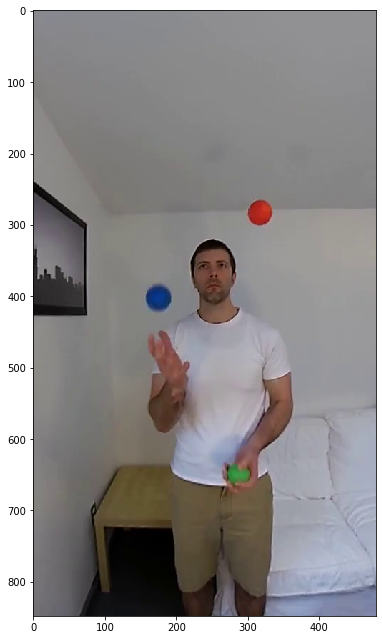

In [61]:
# Load video
cap = cv2.VideoCapture(video_path)

# Get General Info
fps         = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration    = int(frame_count/fps)
width       = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # float
height      = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float

# Read frame
frame_num = 0
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Display
f, ax = plt.subplots(1, 1, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
print('Frames Per Sec FPS = ' + str(fps))
print('Number of Frames   = ' + str(frame_count))
print('Duration [Sec]     = ' + str(duration))
minutes = int(duration/60)
seconds = duration%60
print('Duration [Min:Sec] = ' + str(minutes) + ':' + str(seconds))
print("Width: ", width, ' Height:', height)


## Helper Functions
KeyPoints are in key_lists and have the following format -> [x1,y1,c1,x2,y2,c2...]

Cartesian Points are in pts_lists and have the following format ->[x1,y1,x2,y2...]

In [62]:
def draw_keyPts(img,key_list,color):
    """
    Draws on a color image the key_list given.    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw Key List
    for i in range(0,len(key_list),3):
        if key_list[i+2] != 0: #If confidence score not zero
            (x,y) = int(key_list[i]),int(key_list[i+1])
            cv2.circle(img_to_draw, (x,y), radius= 3, color=color, thickness=-1)

    # Add keypoints to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, 1, 0) 
    return output_img

    
def draw_circle_boundaries(img,pts_list,radius,color):
    """
    Draws on a color image the center and circunference of a circle of size 
    radius centered at the coordinates given by the pts_list.    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw Point List
    for i in range(0,len(pts_list),2):
        (x,y) = int(pts_list[i]),int(pts_list[i+1])
        cv2.circle(img_to_draw, (x,y), radius= 3, color=color, thickness=-1)
        cv2.circle(img_to_draw, (x,y), radius= radius, color=color, thickness=3)

    # Add keypoints to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, .8, 0) 
    return output_img


def draw_circles(img,pts_list,radius,color):
    """
    Draws on a color image the center and circunference of a circle of size 
    radius centered at the coordinates given by the pts_list.   
    """
    
    # Unpack and Define previously known data from video
    frame_num   = videoInfo.current_frame
    
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw Point List
    for i in range(0,len(pts_list[frame_num]),2):
        if pts_list[frame_num][i] is not None:
            (x,y) = int(pts_list[frame_num][i]),int(pts_list[frame_num][i+1])
            cv2.circle(img_to_draw, (x,y), radius= 3, color=color, thickness=-1)
            cv2.circle(img_to_draw, (x,y), radius= radius, color=color, thickness=3)

    # Add  Point List to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, .8, 0)
    
    # Update new data for next frame in video 
    videoInfo.plusOneFrame()
    
    return output_img


def centroid(key_list):
    """
    Determines the centroid in x and y in the key_list given as list.    
    """
    # Centroid Key List
    count_keyPts = 0
    x_sum = 0
    y_sum = 0
    for i in range(0,len(key_list),3):
        if key_list[i+2] != 0: #If confidence score not zero
            count_keyPts += 1
            (x,y) = int(key_list[i]),int(key_list[i+1])
            x_sum += x
            y_sum += y

    if count_keyPts:
        return [int(x_sum/count_keyPts) , int(y_sum/count_keyPts)]
    else: # No hand keypoints detected 
        return None
    
    
class VideoTracker():
    def __init__(self):
        self.current_frame = 0 
    
    def plusOneFrame(self):
        self.current_frame = self.current_frame +1
               

def addFrameNumber(image, frame_count, font_scale, color, thickness):
    """"
    Add frame number to an image.  
    """
        
    # Unpack and Define previously known data from video
    image = np.array(image)
    frame_num   = videoInfo.current_frame
    
    # Add Number
    h,w = image.shape[:2]
    box_startX, box_startY, box_endX, box_endY = 0, 0, int(0.5*w), int(0.2*h) # Box vertices follows golden ratio 
    image[box_startY: box_endY, box_startX:box_endX] = 0                      # Black rectangle in left corner 
    text = "Frame: "+ str(frame_num) + "/" + str(frame_count)
    text_startX, text_startY = 0, box_endY- int(box_endY*0.4)
    cv2.putText(image, text, (text_startX, text_startY),cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)
    
    # Update new data for next frame in video 
    videoInfo.plusOneFrame()
    
    return image


def draw_hand_boundaries(img,left_hand_loc,right_hand_loc,radius,color):
    """
    Draws on a color image the center and circunference of a circle of size 
    radius centered at the coordinates given by the lists: left_hand_loc & right_hand_loc.  
    """
    
    # Unpack and Define previously known data from video
    frame_num   = videoInfo.current_frame
    
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw hand centroid and boundaries 
    if left_hand_loc[frame_num] is not None:
        (x,y) =left_hand_loc[frame_num]
        cv2.circle(img_to_draw, (x,y), radius= 3, color=color, thickness=-1)
        cv2.circle(img_to_draw, (x,y), radius= radius, color=color, thickness=3)
        
    if right_hand_loc[frame_num] is not None:
        (x,y) =right_hand_loc[frame_num]
        cv2.circle(img_to_draw, (x,y), radius= 3, color=color, thickness=-1)
        cv2.circle(img_to_draw, (x,y), radius= radius, color=color, thickness=3)

    # Add keypoints to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, .8, 0)
    
    # Update new data for next frame in video 
    videoInfo.plusOneFrame()
    
    return output_img

## Hand Detection
#### Read File and Define Keypoints of Interest(KoI)

In [63]:
# READ FILE
video_name_part = video_name.split(".")    # sample & mp4 has been split
data_dir  = os.path.join("..","DATASET_Juggling","Juggling_Pattern_Dataset","FullBody_Tracking_Data", video_name_part[0])
data_path = [os.path.join(data_dir, elem) for elem in os.listdir(data_dir)]
with open(data_path[0]) as f:
    data = json.load(f)

person      = 0
right_wrist = 4
left_wrist  = 7
body_keyPts        = data['people'][person]["pose_keypoints_2d"]
right_wrist_keyPts = body_keyPts[3*right_wrist : 3*right_wrist +3]
left_wrist_keyPts  = body_keyPts[3*left_wrist  : 3*left_wrist +3]
right_hand_keyPts  = data['people'][person]["hand_right_keypoints_2d"]
left_hand_keyPts   = data['people'][person]["hand_left_keypoints_2d"]


#### Draw KOI and Hand Boundaries
The hand boundaries are defined by circles of size `radius` 

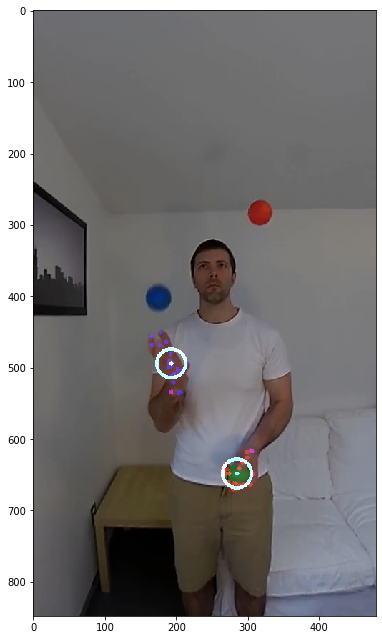

In [64]:
# Wrists
wrist_keyPts = np.hstack((right_wrist_keyPts, left_wrist_keyPts))
color = [255, 0, 255]
out_image = draw_keyPts(frame, wrist_keyPts, color)

# Hands Keypoints
color = [255, 0, 0]
out_image = draw_keyPts(out_image, right_hand_keyPts,color)
color = [0, 0, 255]
out_image = draw_keyPts(out_image, left_hand_keyPts,color)

# Hand Boundaries and Centroid
right_hand_centroid = centroid(right_hand_keyPts)
left_hand_centroid  = centroid(left_hand_keyPts)
hand_centroids = left_hand_centroid + right_hand_centroid
hand_radius, color= 20, [255, 255, 102]
videoInfo = VideoTracker()           # reset to begining (frame zero)
out_image = draw_circles(out_image,[hand_centroids],hand_radius,color)

#out_image = draw_hand_boundaries(out_image,[left_hand_centroid],[right_hand_centroid],hand_radius,color)


# Display 
f, ax = plt.subplots(1, 1, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax.imshow(cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB))
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
# f.tight_layout()
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# ax1.set_title('Original Image', fontsize=50)
# ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# ax2.set_title('KOI Image', fontsize=50)
# ax2.imshow(cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB))


Let's get the hand locations for the entire video  

In [38]:
# Data Directory
video_name_part = video_name.split(".")    # sample & mp4 has been split
data_dir  = os.path.join("..","DATASET_Juggling","Juggling_Pattern_Dataset","FullBody_Tracking_Data", video_name_part[0])
data_path = [os.path.join(data_dir, elem) for elem in os.listdir(data_dir)]

# Keypoint Number
person      = 0
right_wrist = 4
left_wrist  = 7

# Hand Radius (will be automated later) (IDEA: Average of hand area throughout entire video)
hand_radius = 20

# Hand Locations
left_hand_loc  = []
right_hand_loc = []
for i in range(len(data_path)):
    # Read data
    with open(data_path[i]) as f:
        data = json.load(f)

    right_hand_keyPts = data['people'][person]["hand_right_keypoints_2d"]
    left_hand_keyPts  = data['people'][person]["hand_left_keypoints_2d"]
    right_hand_loc.append(centroid(right_hand_keyPts))
    left_hand_loc.append(centroid(left_hand_keyPts))
    

In [39]:
# How many hands were not detected?
print("Times Left Hand not detected: " , len([elem for elem in left_hand_loc if elem == None]))
print("Times Right Hand not detected: ",len([elem for elem in right_hand_loc if elem == None]))
    

Times Left Hand not detected:  7
Times Right Hand not detected:  14


## Ball Detection
#### Read File
Ball Positions are stored for each frame in rows as: x-Pos, y-Pos, x-Pos, ... 

In [46]:
# READ CSV File
balls_loc = []
video_name = "ss441_id_013.MP4"
video_name_part = video_name.split(".") 
file_path = os.path.join("..","DATASET_Juggling","Juggling_Pattern_Dataset","Ball_Tracking_Data", video_name_part[0] + ".csv")
with open(file_path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        balls_loc.append(line)
balls_loc = balls_loc[1:] # Get rid of title

#### Draw

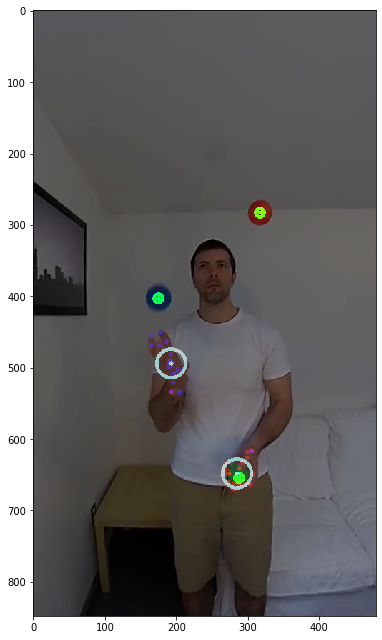

In [49]:
color, ball_radius = [0, 255,0], 6
videoInfo = VideoTracker()           # reset to begining (frame zero)
out_image =draw_circles(out_image, [balls_loc[0]], ball_radius, color)

# Display 
f, ax = plt.subplots(1, 1, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax.imshow(cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB))

# Video Inspection
Enumerate frames, detect hands, and juggling props in a video

In [20]:
%%capture
# Create folder to place output videos at same level directory as this file
try:
    os.mkdir("Output_Video")
except FileExistsError:
    print ("Output Folder is ready already")
    
# Create clip
clip  = VideoFileClip(video_path)

# Add Frame Numbers to Video
font_scale, color, thickness = 1.5, (0, 255, 0), 5
videoInfo = VideoTracker()           # reset to begining
clip = clip.fl_image(lambda image: addFrameNumber(image, frame_count, font_scale, color, thickness))

# Draw hand boundaries to Video
hand_radius, color= 20, [255, 255, 102]
videoInfo = VideoTracker()           # reset to begining
clip = clip.fl_image(lambda image: draw_hand_boundaries(image,left_hand_loc,right_hand_loc,radius,color))


clip = clip.fl_image(lambda image: addFrameNumber(image, frame_count, font_scale, color, thickness))





# Save Enumerated video 
video_name_part = video_name.split(".")    # sample & mp4 has been split
dest_path = os.path.join("Output_Video", video_name_part[0] + "_enumerated." + video_name_part[1])
%time video_clip.write_videofile(dest_path, audio=False)

## Hand State
This is where the background magic happens. The following code blocks will be used to return a list that states everytime a ball is thrown: stating the hand it is thrown from, the ball ID, and the frame where the ball was thrown. With this code you can count throws and even determine the juggling siteswap pattern.   

In [10]:
def within_circle_boundaries(pts_list,center,radius):
    """
    Returns the indeces of the points from pts_list that are within the circumference of a circle
    located at center and with size radius.    
    """    
    # Check Boundary Condition
    (xc,yc) = center
    pts_indeces = []
    for i in range(0,len(pts_list),2):
        (x,y) = int(pts_list[i]),int(pts_list[i+1])
        if math.sqrt((xc-x)**2 + (yc-y)**2) < radius:
            pts_indeces.append(int(i/2))

    return pts_indeces


Notes: if ball leaves frame from any side besides top then it has fallen

In [13]:
# Starting Throws (keep track of thrown balls before hands reach <2)
starting_list = []

#----------
thrown_history = []
ball_thrown = False
        

In [19]:
i=30

# while hand has reach <2 (max one ball per hand)

prev_balls_in_left_hand  = within_circle_boundaries(balls_loc[0], left_hand_centroid, hand_radius)
prev_balls_in_right_hand = within_circle_boundaries(balls_loc[0], right_hand_centroid, hand_radius)

#read new hand centroids
balls_in_left_hand  = within_circle_boundaries(balls_loc[i], left_hand_centroid, hand_radius)
balls_in_right_hand = within_circle_boundaries(balls_loc[i], right_hand_centroid, hand_radius)

# Check max one ball per hand condition 
if len(balls_in_left_hand)<2 and len(prev_balls_in_right_hand)<2:
    
    # Left Throw Detection
    if len(balls_in_left_hand)<len(prev_balls_in_left_hand):
        thrown_history.append(('L',prev_balls_in_left_hand[0],i)) #save (hand,ball,frame)
        ball_thrown = True
        
    # Right Throw Detection
    if len(balls_in_right_hand)<len(prev_balls_in_right_hand):
        thrown_history.append(('R',prev_balls_in_right_hand[0],i))
        ball_thrown = True

else: # More than 1 ball in a hand detected
    break

    
# Check Special Juggling Pattern Cases (after second throw)
if ball_thrown and len(thrown_history)>1:
    
    if thrown_history[-1][0] == thrown_history[-2][0]: #Throw from same hand
        
        # Two Left Throws
        if thrown_history[-1][0] == 'L':
            if balls_in_right_hand: # then add a '2' in the Site Swap Notation
                thrown_history.append(thrown_history[-1])
                thrown_history[-2] = ('R',balls_in_right_hand[0],i)
            else: # if empty then add a '0' in the Site Swap Notation
                thrown_history.append(thrown_history[-1])
                thrown_history[-2] = ('R',-1,i)
                
        # Two Right Throws(PENDING)
        if thrown_history[-1][0] == 'L':
            if balls_in_right_hand: # then add a '2' in the Site Swap Notation
                thrown_history.append(thrown_history[-1])
                thrown_history[-2] = ('R',balls_in_right_hand[0],i)
            else: # if empty then add a '0' in the Site Swap Notation
                thrown_history.append(thrown_history[-1])
                thrown_history[-2] = ('R',-1,i)
                
                
    
    

print(prev_balls_in_left_hand, prev_balls_in_right_hand)
print(balls_in_left_hand, balls_in_right_hand)
print(thrown_history)    

[1] []
[] []
[('L', 1, 30)]


In [26]:
a=[]
if True:
    print(a[0])

IndexError: list index out of range